# Interview Data Visualization Task Siemens 
### Research Scientist for Visual Data Science
Christian Graf, 6th November 2020

### Library Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [132]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

In [3]:
import lime
import lime.lime_tabular

### Data Loading

In [4]:
df = pd.read_csv("../data/bank-additional-full.csv", sep=";")

### Data Overview

Getting an initial overview of the data

In [5]:
df.describe()

age      duration      campaign         pdays      previous  \
count  41188.00000  41188.000000  41188.000000  41188.000000  41188.000000   
mean      40.02406    258.285010      2.567593    962.475454      0.172963   
std       10.42125    259.279249      2.770014    186.910907      0.494901   
min       17.00000      0.000000      1.000000      0.000000      0.000000   
25%       32.00000    102.000000      1.000000    999.000000      0.000000   
50%       38.00000    180.000000      2.000000    999.000000      0.000000   
75%       47.00000    319.000000      3.000000    999.000000      0.000000   
max       98.00000   4918.000000     56.000000    999.000000      7.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx     euribor3m   nr.employed  
count  41188.000000    41188.000000   41188.000000  41188.000000  41188.000000  
mean       0.081886       93.575664     -40.502600      3.621291   5167.035911  
std        1.570960        0.578840       4.628198      1.734447     72.251528  
min       -3.400000       92.201000     -50.800000      0.634000   4963.600000  
25%       -1.800000       93.075000     -42.700000      1.344000   5099.100000  
50%        1.100000       93.749000     -41.800000      4.857000   5191.000000  
75%        1.400000       93.994000     -36.400000      4.961000   5228.100000  
max        1.400000       94.767000     -26.900000      5.045000   5228.100000

There are 41188 entries with the following columns:

In [6]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [7]:
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

The data types are mixed between int, float and categorical. Checking for missing values and Nan: There are no NaNs

In [8]:
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

## First Task
Searching for Client groups that are likely to maximize outcome of marketing campaign

### Data Exploration

#### Target Variable
I will start by looking at the distribution of the target variable. The target variable comes as cathegorical data "no" and "yes". There are no missing values. For a classification tasks this should be encoded as 0 and 1.

In [9]:
df["y"].unique()

array(['no', 'yes'], dtype=object)

<AxesSubplot:>

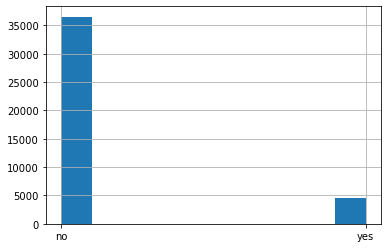

In [10]:
df["y"].hist()

The data set is imbalanced with nearly ten times more customers not subscribing for the term deposit than the ones who do. This needs to be taken into account for a prediction task.

#### Features

Exploring the features. Plotting a histogram of each to get a first impression

age


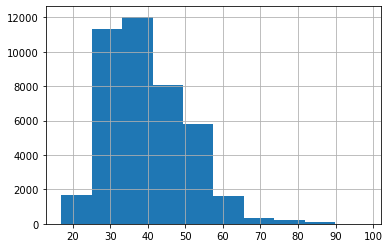

job


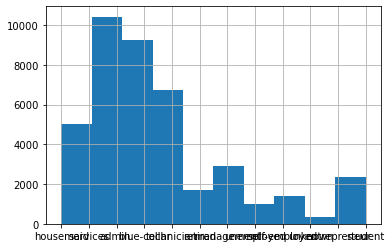

marital


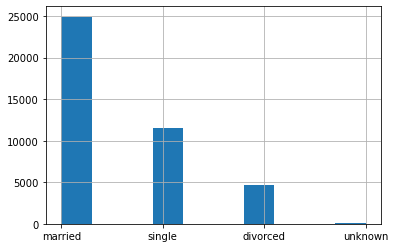

education


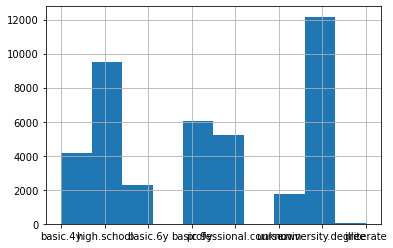

default


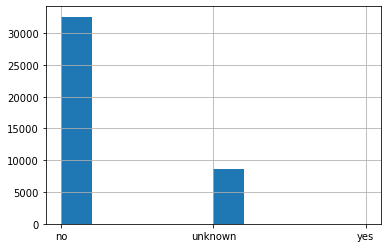

housing


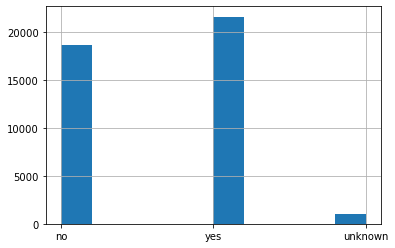

loan


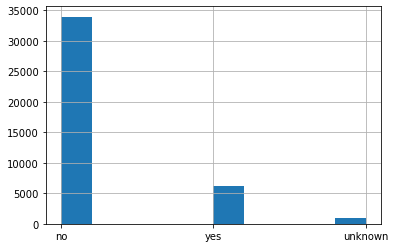

contact


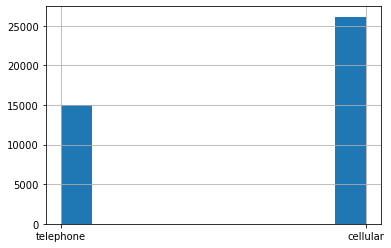

month


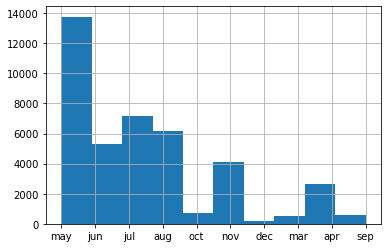

day_of_week


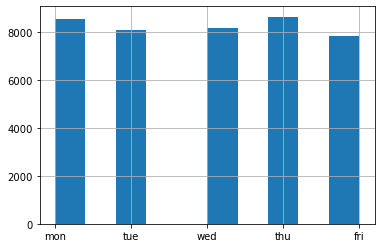

duration


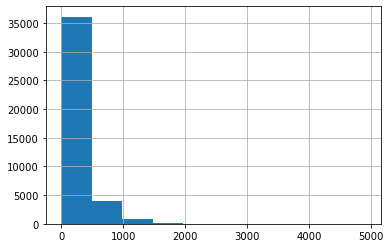

campaign


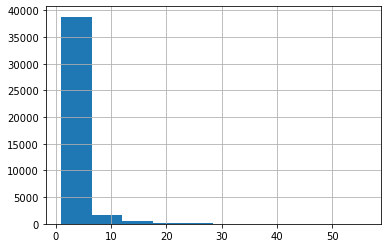

pdays


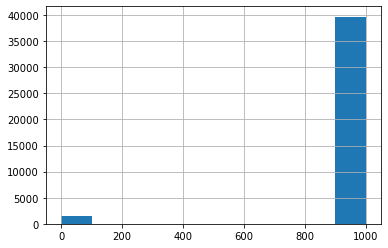

previous


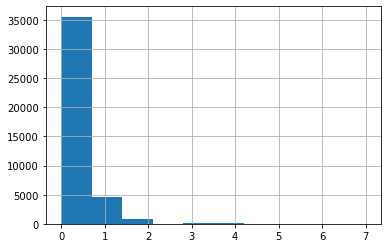

poutcome


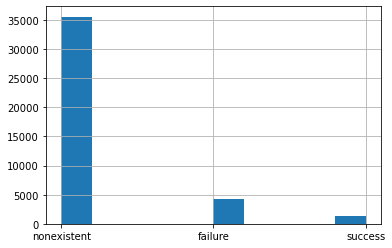

emp.var.rate


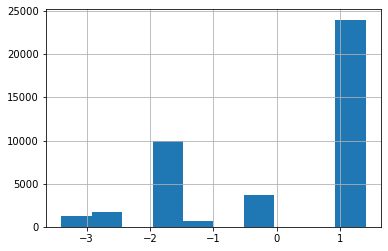

cons.price.idx


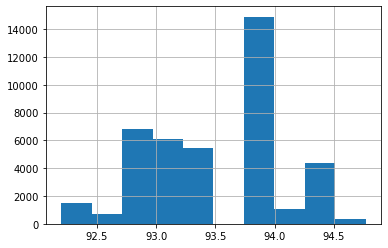

cons.conf.idx


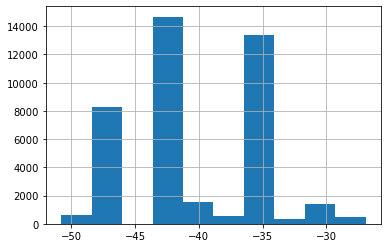

euribor3m


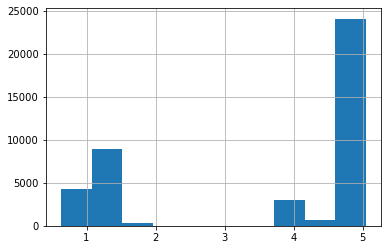

nr.employed


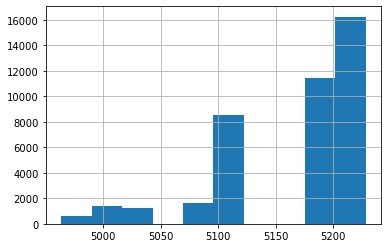

y


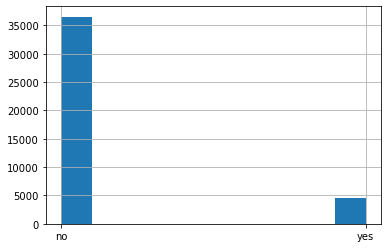

In [11]:
for feature in df.columns:
    print(feature)
    df[feature].hist()
    plt.show()

Observations:
- There are several features with "unknown" variables. For a prediction task we need to discuss how to handle them
- Outliers: Most distribution do not suffer heavily from outliers, however **previous, pdays, campaign and duration** should be looked after
- The numerical values differ largely in size / range. They should be standardized before any prediction
- Following the description of the variables, the duration observable should not be used for any prediction task as it is not known prior to the call and may be highly correlated to the target variable

Changing the target variabel to a numerical value where yes = 1 and no = 0 for easier handling

In [12]:
df["y"] = (df["y"] == "yes").astype(int)

<AxesSubplot:>

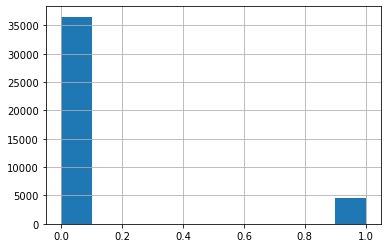

In [13]:
df["y"].hist()

#### Correlations

Getting a first impression of the correlation between the numerical features and target variable by looking at the correlation coefficients

In [14]:
df.corr()

age  duration  campaign     pdays  previous  \
age             1.000000 -0.000866  0.004594 -0.034369  0.024365   
duration       -0.000866  1.000000 -0.071699 -0.047577  0.020640   
campaign        0.004594 -0.071699  1.000000  0.052584 -0.079141   
pdays          -0.034369 -0.047577  0.052584  1.000000 -0.587514   
previous        0.024365  0.020640 -0.079141 -0.587514  1.000000   
emp.var.rate   -0.000371 -0.027968  0.150754  0.271004 -0.420489   
cons.price.idx  0.000857  0.005312  0.127836  0.078889 -0.203130   
cons.conf.idx   0.129372 -0.008173 -0.013733 -0.091342 -0.050936   
euribor3m       0.010767 -0.032897  0.135133  0.296899 -0.454494   
nr.employed    -0.017725 -0.044703  0.144095  0.372605 -0.501333   
y               0.030399  0.405274 -0.066357 -0.324914  0.230181   

                emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
age                -0.000371        0.000857       0.129372   0.010767   
duration           -0.027968        0.005312      -0.008173  -0.032897   
campaign            0.150754        0.127836      -0.013733   0.135133   
pdays               0.271004        0.078889      -0.091342   0.296899   
previous           -0.420489       -0.203130      -0.050936  -0.454494   
emp.var.rate        1.000000        0.775334       0.196041   0.972245   
cons.price.idx      0.775334        1.000000       0.058986   0.688230   
cons.conf.idx       0.196041        0.058986       1.000000   0.277686   
euribor3m           0.972245        0.688230       0.277686   1.000000   
nr.employed         0.906970        0.522034       0.100513   0.945154   
y                  -0.298334       -0.136211       0.054878  -0.307771   

                nr.employed         y  
age               -0.017725  0.030399  
duration          -0.044703  0.405274  
campaign           0.144095 -0.066357  
pdays              0.372605 -0.324914  
previous          -0.501333  0.230181  
emp.var.rate       0.906970 -0.298334  
cons.price.idx     0.522034 -0.136211  
cons.conf.idx      0.100513  0.054878  
euribor3m          0.945154 -0.307771  
nr.employed        1.000000 -0.354678  
y                 -0.354678  1.000000

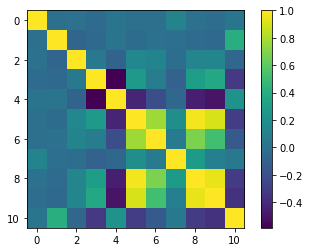

In [15]:
plt.imshow(df.corr())
plt.colorbar()
plt.show()

Observations:
- We can see large correlations between y and duration, which is expected
- Larger anti-correlations between y and pdays, emp.var.rate, euribor3m, nr.employed
- moderate correlation between y and previous
- Some variables are highly correlated with each other as for example: euribor3m & nr.employed, or euribor3m & emp.var.rate

In order to get a feeling for the correlations of also the categorical variables, I plot the distributions for y == 0 and y == 1

### ATTENTION: BUG here in share x

age


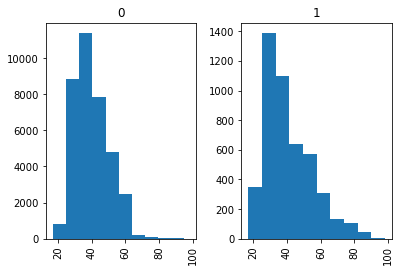

job


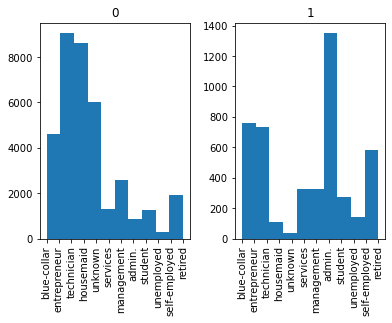

marital


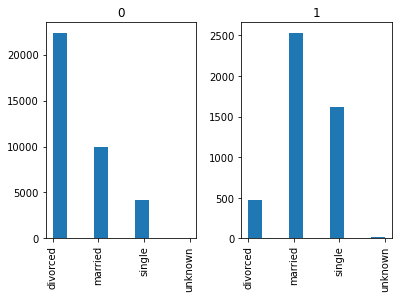

education


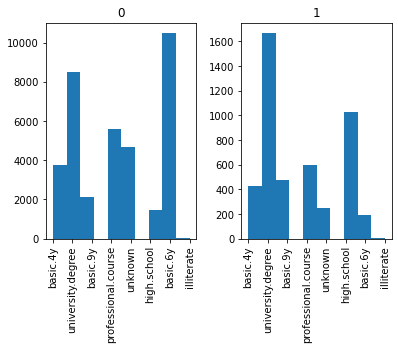

default


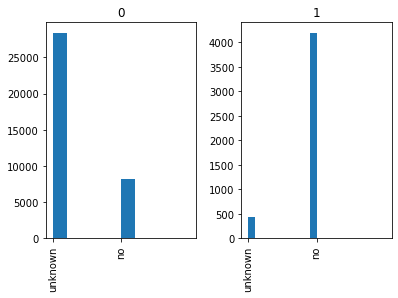

housing


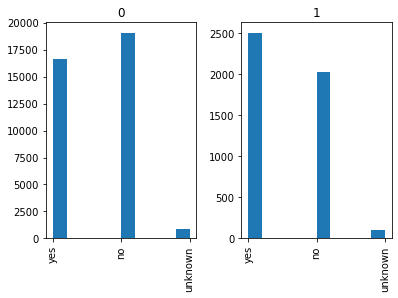

loan


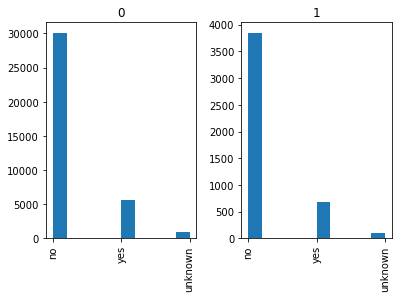

contact


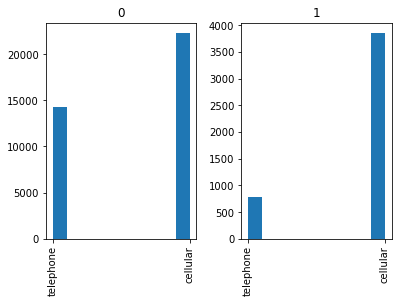

month


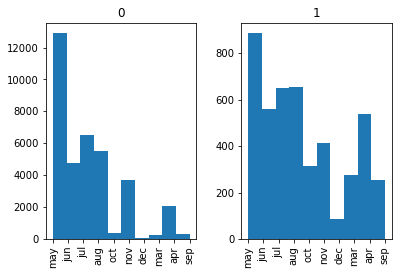

day_of_week


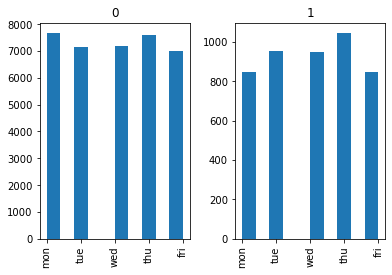

duration


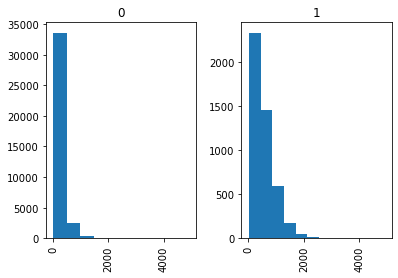

campaign


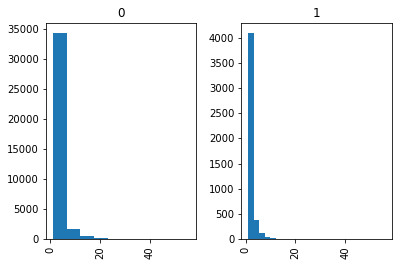

pdays


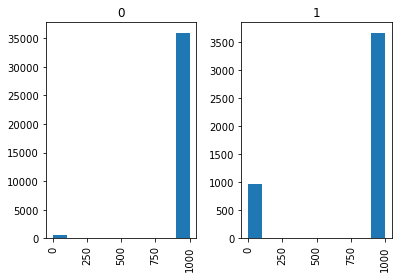

previous


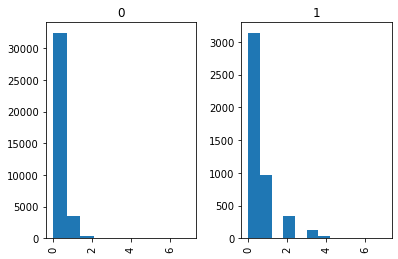

poutcome


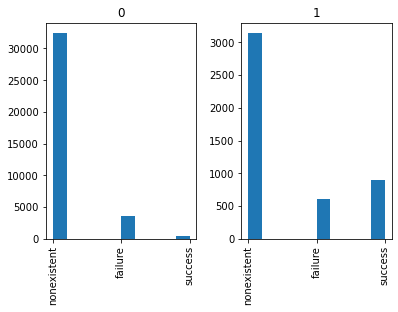

emp.var.rate


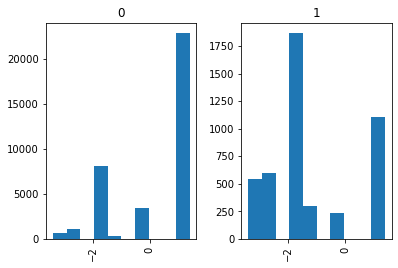

cons.price.idx


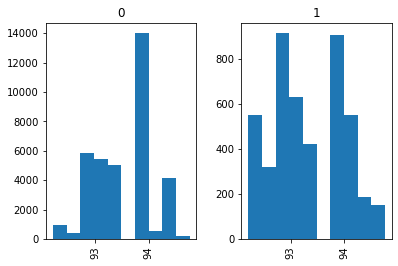

cons.conf.idx


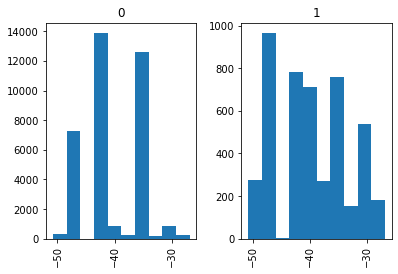

euribor3m


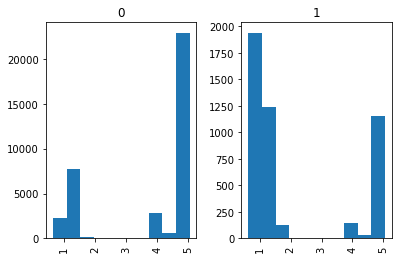

nr.employed


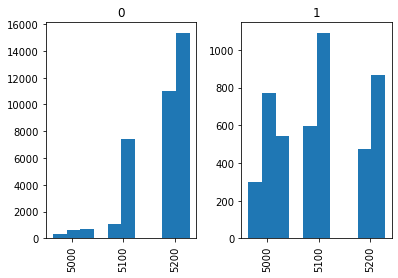

y


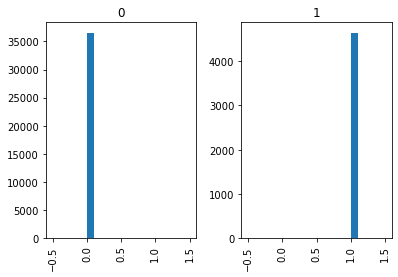

In [16]:
for feature in df.columns:
    print(feature)
    df.hist(column=feature, by="y", sharex=True, sharey=False)
    plt.show()

Observations:
- We can see that the distributions differ substantially for job, marital, education and default
- There seems to be correlation with y in the age distribution, even though the correlation coefficients were close to 0. We see, that y==1 for the younger customers (age < 20) and the older customers (age > 60). Probably binning the data into a few age bins would be beneficial to investigate this further.
- the marketing campaigns seem to be less succesfull for divorced customers
- Higher education seems to lead to more successful outcomes
- Having no credit in default seems to be beneficial. However, as the other option is only "unknown", it is not clear what the predictive power is for this variable. Therefore I will not use it for any recommendations.
- Customers with housing loan a slightly favored to deliver succesful outcomes
- Loan seems to be a not a good predictor on its own
- A few months seem to be favored for a successful outcome. This however could also be due to correlations with the economic enviroment, as the euribor etc.
- The day_of_week seems to be a weak predictor. Monday and Friday are slightly less favored for a positive outcome. However, also here the effect may not be due to the weekday itself but due to correlations with other variables, or a shift in the systematics. Eg, In former days the marketing campaigns could be more often held on mondays, while in more recent years it was more often on tuesdays, etc.
- Campaign observable does not seem to be a high quality predictor
- Having low pDays seem to help reasonably for a positive outcome. Probably this is because pdays == 999 when the person is not contacted before. Again, making this a categorical feature could help, or investigate the lower part in more detail
- Higher values in previous seem to be beneficial
- Positive outcome of former campaigns also helps considerably
- The conclusions from the economic predictors as euribor etc. are in line with what we observed before with the correlation coefficients
- cons.conf.idx and cons.price.idx are not very conclusive from a visual inspection

### Recommendations

First recommendations based on historical data. I am putting the strength of the recommendation in parantheses behind every recommendation.

Customers:
- The customers are most likely to react positive to a marketing campaign if they are relatively young (age < 20) or old (age > 60). (medium)
- From a job perspective, admins are likely to be beneficial, while technicians and housmaids are not. (medium/strong)
- Marketing campaigns are less likely to be successfull for divorced customers (strong)
- Higher educated customers are more likely to get a positive outcome (medium) 

Campaing related:
- Having contacted the customer before seems to be beneficial for the outcome (weak/medium)
- If the prior contact lead to a success this also helps (weak/medium)

Economic context:
- Performing the marketing campaigns in an economic environment with a low euribor, low number of employees, lower consumer price index and lower employment variation rate is beneficial. (weak) I am putting the predictive power to weak here, because in general I would be cautious about these factors, as the economic context may be highly correlated to the time the marketing campaigns were performed. Thus, correlations with a change in the campaign itself or the people performing the campaign may be factored in here. Additionally, there may be correlations over time that do not directly come from the economic context. Thus, I would perform further studies before relying too much on the economic context as a predictor for the outcome of the marketing campaign.

No Recommendations are drawn from the following columns:
- default: As the columns are only "no" and "unknown" it is not clear how to handle this. "unknown" could include an abitrary amount of "no" or "yes". A a correlation seems to be present, I would recommend to investigate this observable further and try to gether better data
- housing: The correlation is not very strong
- loan: No correlation visible
- contact by mobile/phone. Correlation seems to be present and favores calling customers by cellular. This however, may be misleading, as the correlation may initially come from differences in education/age. Cross correlations should be investigate here before drawing further conclusions
- Months and week days: Especially some month seem to be beneficial, however, this may come from different factors. Cross correlations need to be investigated in order to draw conclusions.
- Duration should not be used for any predictive measures as it is not known before calling the customer


### Further Comments

- I am assuming that the campaign did not change substantially over time, or the systematics with which persons are beeing contacted. For example it could be that due to a change in the customer structure different groups of people were contacted at different stages / economic context. As we do not see a large correlation between e.g., euribor and age, this is rpobably a valid assumption

- Here I used the full data set in order to derive recommendations. Ideally, I would like to derive them from a training data set and validate the hypotheses on the test data set. Even though we just derived recommendations from historic data in an exploratory way, in a real life setting, they would probably be used as if they are predictions. Thus, the data set should be splitted. As in this task it was explicitly mentioned that it is not a prediction task, I used the full data set.

- Ideally, I would like to investigate further correlations between the categorical features itself in order to track down better recommendations.

## Second Task

### Predictive modelling

- I would use the sklearn library to perform the follwing steps to get a predictive modelling.

- We need to perform some steps in data transformation:
    - The categorical data should be transformed to oneHotEncoded data.
    - The target y was already transformed to numerical values
    - In general, ML algorithms benefit from standardized numerical values, e.g. Mean=0, Std=1

- The data set should be splitted into train test set. Test set with about 20% of the data are around 8000 events and should be enough

- A pipeline should be build to handle train and test data the same way

- We can test several models, I would suggest logistic regression, decision tree, boosted decision tree, random forest and support vector machine here. Neural networks could also be tested here, but intuitivle I would say that a random forest will produce already reasoably good results.

- I would carefully select the features we want to use. For example "duration" should not be used. I would be hesistant to use the economic features (as euribor) becuase of their intrinsic correlation with the time.

- Training on the training set

- We should take care of the imbalanced data. This means training with a balanced data set should be beneficial

- Hyper parameter tuning using grid search and cross-validation

- Outcome of the training should be evaluated on the test set.

In [17]:
df["y_num"] = df["y"]

In [71]:
allCat = ["job", "marital", "education","default", "housing", "loan",
                "contact", "month", "day_of_week", "poutcome"]

In [72]:
allNum = ["age", "campaign", "pdays", "duration", "previous", "emp.var.rate", 
                "cons.price.idx", "cons.conf.idx","euribor3m", "nr.employed"]

In [115]:
features = ["age", "job", "marital", "education", "housing", "loan"]

In [116]:
num_features = []
cat_features = []

for f in features:
    if f in allCat:
        cat_features.append(f)
    else:
        num_features.append(f)

In [117]:
cat_features

['job', 'marital', 'education', 'housing', 'loan']

In [118]:
num_features

['age']

In [119]:
preprocessor = ColumnTransformer([("numerical", StandardScaler(), num_features), 
                                  ("categorical", OneHotEncoder(sparse=False, handle_unknown="ignore"),
                                   cat_features)])

In [133]:
classifier = RandomForestClassifier(max_depth=12, min_samples_split=2, n_estimators = 200, class_weight="balanced", random_state=42)

In [134]:
model = Pipeline([("preprocessor", preprocessor), 
                     ("model", classifier)])

In [135]:
X = df[features]
y = df["y_num"]

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [137]:
model.fit(X_train, y_train)

/Applications/anaconda3/envs/reactTemplate/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/envs/reactTemplate/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('numerical', StandardScaler(copy=True, with_mean=True, with_std=True), ['age']), ('categorical', OneHotEncoder(categorical_features=None, categori...ators=200, n_jobs=None, oob_score=False,
            random_state=42, verbose=0, warm_start=False))])

In [138]:
y_predict = model.predict(X_test)

/Applications/anaconda3/envs/reactTemplate/lib/python3.7/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)


In [139]:
accuracy_score(y_test, y_predict)

0.7319737800437

Building OHE feature names

In [141]:
ohe_cats = model.named_steps["preprocessor"].named_transformers_["categorical"].categories_
new_ohe_features = [f"{col}__{val}" for col, vals in zip(cat_features, ohe_cats) for val in vals]
all_features = num_features + new_ohe_features

### Trying out LIME for explainable AI

Problem: Not clear how to use with current pipeline and the categorical data

In [142]:
explainer = lime.lime_tabular.LimeTabularExplainer(preprocessor.transform(X_train),
                                                   mode="classification",
                                                   feature_names = all_features)


/Applications/anaconda3/envs/reactTemplate/lib/python3.7/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)


In [143]:
predict_fn = lambda x: classifier.predict_proba(x)

In [144]:
X_test_transformed = preprocessor.transform(X_test)

/Applications/anaconda3/envs/reactTemplate/lib/python3.7/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)


In [150]:
i = 2
exp = explainer.explain_instance(X_test_transformed[i], predict_fn, num_features=50)
exp.show_in_notebook()
print(X_test.iloc[i])

age                   33
job          blue-collar
marital          married
education       basic.9y
housing               no
loan                  no
Name: 32206, dtype: object
